## Closed Loop Design and Testbed Construction
BioE 599: Advanced Biological Control Systems - Assignment #1

# Comments

In [21]:
!pwd

/Users/jlheller/home/Technical/repos/BIOEN-437/homework_grading/hw1/Tommy Primo


1. Nicely sectioned narrative, which I appreciate.
1. It doesn't seem that you got the flakifier to work. One problem was a bug in ``makeFlakifier``. More details in-line. I took off 10 points.

#### Import Functions

In [1]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML
import random
ctl.__version__


'1.0.7'

## Question 1: ODE Biomodel
__Objectives__

1. Define Model as well as input controller and output measurement : __COMPLETE__
2. Specify Control Objectives : __COMPLETE__

__Control Objectives__

1. Reach Set point 6 or 100 (Other Model)

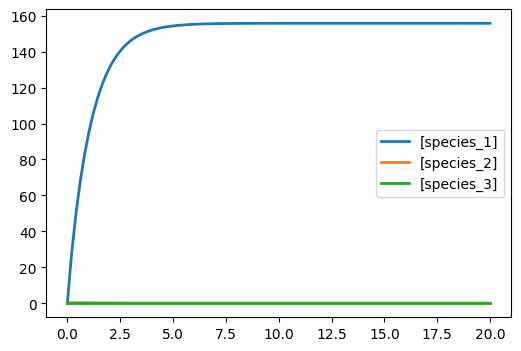

In [2]:
"""
- Bio Models Input:
- Contains wolf model (Tester) and genetic toggle switch in E. Coli
"""
wolfurl = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
url = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000507.2?filename=BIOMD0000000507_url.xml"
BioCSBML = ctl.ControlSBML(url, input_names=['species_1'], output_names=['species_1'])
BioRR = BioCSBML.roadrunner
BioRR.simulate(0, 20, 100)
BioRR.plot()
# Return Antimony
#print(BioRR.getAntimony())

#### Plot System

In [3]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, output_labels=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(0, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(output_labels)
    if not is_plot:
        plt.close()
    return t, y, ax

#### Simulating OLS

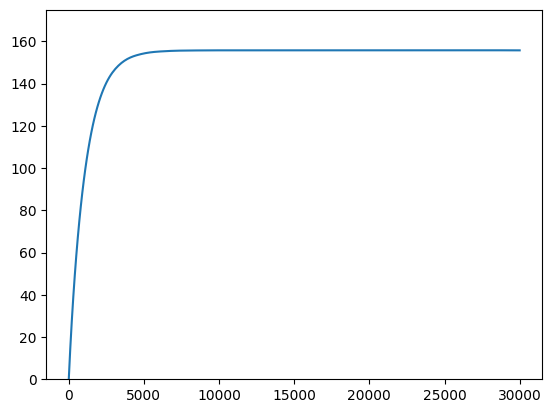

In [4]:
# Simulate the open loop system with no change in its input (at)
biomodel_sys = BioCSBML.makeNonlinearIOSystem("biomodel")
ts = ctl.simulateSystem(biomodel_sys, end_time=30)
plt.ylim([0,175])
_ = plt.plot(ts)

## Question 2: Construction of CLS1
__Objectives__
1. Construct PI Controller : __COMPLETE__
2. Apply PI Controller to OLS Using Control Objectives  and Plot Time Response : __COMPLETE__

__Control Objectives__

1. Reach Set point 6
2. Eliminate Oscillations of x

In [5]:
"""
- Define Control Objectives
"""
reference_setpoint = 100 # Change to 6 for wolf model

#### PI Controller

In [6]:
def makePIController(setpoint=0, Kp=1, Ki=1):
    """
    - makePIController: Controller that controllers given input for a desired output
    - setpoint (float): point wanting to achieve with controller
    - Kp (float): Coefficient for proportional controller
    - Ki (float): Coefficient for Integration controller
    """
    
    def updatefcn(_, __, u, ___):
        """
        - updatefcn: Accumulates controller error and returns
        - u (array-float): input of controller
        """
        return setpoint - u[0]
    
    def outputfcn(_, x, u, __):
        """
        - outputfcn: Calculates output from input
        - x: state of controller
        - u: input of controller
        """
        error = setpoint - u[0]
        output = Ki*x[0] + Kp*error
        return output
    
    # Contructor
    controller = control.NonlinearIOSystem(
      updatefcn,
      outputfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    
    return controller

# Testing...
controller = makePIController()
assert("NonlinearIOSystem" in str(type(controller)))

#### Interconnect Model

In [7]:
def makeInterconnect(sys_name=biomodel_sys, **kwargs):
    """
    Create an Interconnect object for the Wolf closed loop system.
    
    Parameters
    ----------
    wolf_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(**kwargs)
    closed_sys = control.interconnect(
      [biomodel_sys, controller_sys],       # systems
      connections=[
        ['biomodel.species_1', 'controller_sys.out'],
        ['controller_sys.in',  'biomodel.species_1'],
      ],
      inplist=["controller_sys.in"],
      outlist=["biomodel.species_1"],
    )
    return closed_sys

#### Simulating Controller Plot

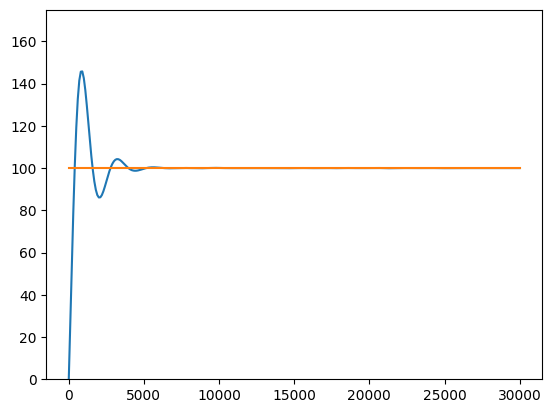

In [8]:
closed_sys = makeInterconnect(setpoint=reference_setpoint, Kp=1, Ki=8)
end_time = 30
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["species_1"])
ts["setpoint"] = reference_setpoint
plt.ylim([0,175])
_ = plt.plot(ts)

## Question 3: Flakifier
__Objectives__

1. Create Flakifier System : __COMPLETE__
2. Construct CLS2 by interconnecting PI Controller and Flakifier : __COMPLETE: KINDA__
3. Find smallest ``p`` value and tune Controller with smallest ``p`` Flakifier Value

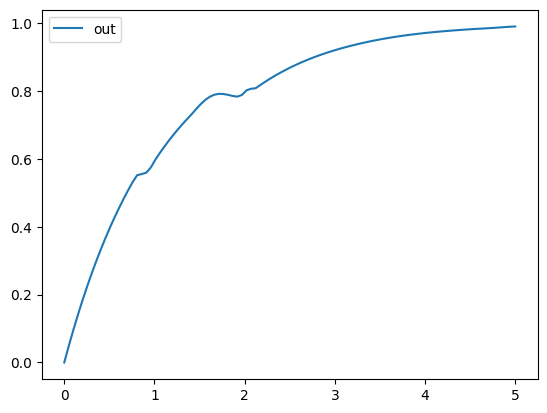

In [18]:
def makeFlakifier(Kf=1,p=0.8):
    """
    - makeFlakifier: Flakifier system cases input signals to be lost based on a given probability
    - p (float): Flakifier probability
    """
    
    def updatefcn(_, x, u, ___):
        """
        - updatefcn: Return the signal
        - u (array-float): input signal
        """
        return u[0]
    
    def outputfcn(_, x, u, ___):
        """
        - outputfcn: Returns the input if signal is above probability, else returns zero
        - u (array-float): input signal
        """
        signal = np.random.rand() >= p
        return u[0] if signal else 0
    
    def smoothupdate(_, x, u, __):
        """
        - smoothupdate: Returns smooth differential equation
        - x: state
        - u: Input
        """
        number = np.random.rand(1) <= p
        # if number[0] <= p:  // bug
        if number:
            dx= Kf*u[0] - Kf*x[0]
        else:
            dx = 0
        return dx
    
    def smoothoutput(_, x, u, __):
        """
        - smoothoutput: Returns the states of the flakifier
        """
        return x[0]
        
    
    # Constructor - change between updatefcn and outputfcn to smoothupdate or smoothoutput
    flakifier = control.NonlinearIOSystem(
      smoothupdate,
      smoothoutput,
      states=1,
      inputs=['in'],
      outputs=['out'], name='flakifier_sys')
    
    return flakifier

# Testing...
flakifier_sys = makeFlakifier()
assert("NonlinearIOSystem" in str(type(flakifier_sys)))

# Plotting Flakifier
_, __, ___ = plotSys(flakifier_sys, forced_input=[1], is_plot=True)

#### Interconnecting Controller, Flakifier and OLS

In [19]:
def makeFlakifierInterconnect(given_sys=biomodel_sys, **kwargs):
    """
    Create an Interconnect object for the Flakifier closed loop system.
    
    Parameters
    ----------
    flakifier_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(**kwargs)
    closed_sys = control.interconnect(
      [biomodel_sys, flakifier_sys, controller_sys],       # systems
      connections=[
        ['flakifier_sys.in', 'controller_sys.out'],
        ['biomodel.species_1',  'flakifier_sys.out'],
        ['controller_sys.in', 'biomodel.species_1'],
      ],
      inplist=["controller_sys.in"],
      outlist=["biomodel.species_1"],
    )
    return closed_sys

**comment**
1. flakifier_sys should be constructed instead of makeFlakifier. Otherwise, you can't do experiments with different flakifiers. As it stands, you're always using the default parameter values.
This has $p=0.05$, which means that you mostly have a 0 output.

#### Simulating Flakier Plot

In [20]:
closed_sys = makeFlakifierInterconnect(setpoint=reference_setpoint, Kp=1, Ki=8) # Reduce Ki to reach setpoint
end_time = 30
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["species_1"])
ts["setpoint"] = reference_setpoint
plt.ylim([0,175])
_ = plt.plot(ts)

ValueError: Outputs could not be calculated.

## Question 4: Summary Challenges
1. CLS 1 - No Challenges
2. CLS 2 - Flakifier works but Interconnecting with CLS 1 kept giving an ``Algebriac loop detected`` Error for any value of p outside of 1 and 0 for ``makeFlakifier()`` function using the ``updatefcn`` and ``outputfcn``. Smooth Flakifier used by changing the ``makeFlakifier()`` constructor functions to ``smoothupdate()`` and ``smoothoutput()`` Works and shows smooth plot but interconnecting with CLS 1 gives a Value Error ``Outputs could not be calculated``